In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random

2023-03-03 17:08:43.918857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
meta_df = pd.read_csv('../train_val_test_split/train_val_test_GoogleAudioSet.csv', index_col=0)
meta_df

,file,source,category,weight,fold
0,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,0
1,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,8
2,../data/interim/GoogleAudioSet_unbalanced_list...,Google_nature,0,1,5
3,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,1
4,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,1
...,...,...,...,...,...
13662,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,5
13663,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,3
13664,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,8
13665,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,8


In [3]:
def load_df_pkl(filename, indices):
    import pickle
    import pandas as pd
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    df = output[indices]

    # close the file
    file.close()
    return df

In [6]:
## data preprocessing
def df_preproc(df):

    # replacing the inf values by NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    train_category = df[df['fold']<8]['category']
    val_category = df[df['fold']==8]['category']
    test_category = df[df['fold']==9]['category']

    train_source = df[df['fold']<8]['source']
    val_source = df[df['fold']==8]['source']
    test_source = df[df['fold']==9]['source']
    
    train_weight = df[df['fold']<8]['weight']
    val_weight = df[df['fold']==8]['weight']
    test_weight = df[df['fold']==9]['weight']

    train_df = df[df['fold']<8].drop(columns=['fold','category','source','weight'])
    val_df = df[df['fold']==8].drop(columns=['fold','category','source','weight'])
    test_df = df[df['fold']==9].drop(columns=['fold','category','source','weight'])

    # replace the nan by mean
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline

    transformer = Pipeline(steps=[
           ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
          ,('scaler', StandardScaler())
    ])

    transformer.fit(train_df)
    train_df = pd.DataFrame(transformer.transform(train_df), columns=train_df.columns)
    val_df = pd.DataFrame(transformer.transform(val_df), columns=val_df.columns)
    test_df = pd.DataFrame(transformer.transform(test_df), columns=test_df.columns)
    
    return train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight


In [7]:
# train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)

# Shared model parameters

In [8]:
# # https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
# loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# my_classes = ['city', 'nature']
# weighted_metrics=['accuracy'] # or []
# loss_weights=None # or None
# learning_rate=0.001

# Sequential_model = [
#     tf.keras.layers.Input(shape=(60), dtype=tf.float32),
#     tf.keras.layers.Dropout(.5),
#     tf.keras.layers.Dense(30, activation='relu'),
# #     tf.keras.layers.Dropout(.5),
# #     tf.keras.layers.Dense(30, activation='relu'),
#     tf.keras.layers.Dense(2)
# ]

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=3,
#                                             restore_best_weights=True)

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

def get_model():
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(23)
    np.random.seed(23)
    python_random.seed(23)

    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(60), dtype=tf.float32),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(30, activation='relu'),
#     tf.keras.layers.Dropout(.5),
#     tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(2)
])
    
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  weighted_metrics=['accuracy'],
                  metrics=['accuracy'])


    return model

# Raw indices

In [10]:
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices'))
    
df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)

train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)

df

,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,Ht,...,H_gamma,H_GiniSimpson,RAOQ,AGI,ROItotal,ROIcover,category,fold,source,weight
0,2224.839429,1.942012e-10,0.01,-0.055097,3.955750,73.135448,-11.971474,0.652570,0.252015,0.966358,...,10534.849647,0.894660,0.237498,1.355972,8,1.821574,1,0,Google_city,1
1,785.000000,-1.113117e-09,0.01,0.072047,3.946318,73.020601,-12.891607,0.058714,0.226683,0.935924,...,4255.638968,0.919609,0.028679,2.121209,0,0.000000,1,8,Google_city,1
2,1773.400000,-1.587719e-09,0.01,-0.391271,30.064412,73.020601,-12.021679,3.558738,0.250563,0.769328,...,29546.808824,0.981489,0.409997,2.053207,1,0.000000,0,5,Google_nature,1
3,3559.500000,-1.639128e-11,0.01,-0.103153,4.906579,73.020597,-10.975547,0.976974,0.282633,0.952502,...,36440.686429,0.989522,0.473169,1.868765,3,0.963374,1,1,Google_city,1
4,2644.400000,3.917143e-10,0.01,0.027781,5.769542,73.020601,-12.805609,1.818748,0.228939,0.922281,...,17712.890483,0.981764,0.304511,1.984243,0,0.000000,1,1,Google_city,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13662,1841.400000,-6.563962e-10,0.01,-0.413531,11.487023,73.020601,-13.898317,3.993134,0.201876,0.874060,...,18923.354813,0.975606,0.199140,2.711269,10,1.530471,1,5,Google_city,1
13663,1422.800000,1.285970e-09,0.01,0.282130,4.558244,73.020601,-9.971991,-0.017257,0.317251,0.969655,...,9919.647364,0.974021,0.077812,1.551653,0,0.000000,1,3,Google_city,1
13664,1703.600000,-1.293607e-10,0.01,-0.093959,16.096061,73.020601,-40.683586,30.284005,0.009243,0.737921,...,39232.305436,0.986211,0.607940,136.099564,0,0.000000,1,8,Google_city,1
13665,2172.600000,7.361174e-10,0.01,0.002022,5.816957,73.020601,-11.690019,1.882262,0.260315,0.934288,...,17011.372795,0.984618,0.221118,1.689392,1,0.000000,1,8,Google_city,1


In [11]:
# check the weight
df.groupby(['source'])['weight'].sum()

source
Google_city      6687
Google_nature    6980
Name: weight, dtype: int64

In [12]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 2)                 62        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


2023-03-03 17:10:02.816554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
history = model.fit(x=train_df,
                    y=train_category,
                    epochs=50,
                    validation_data=(val_df, val_category),
                    callbacks=callback,
                    sample_weight=train_weight)


Epoch 1/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7275 - accuracy: 0.5760 - weighted_accuracy: 0.5760 - val_loss: 0.6479 - val_accuracy: 0.6392 - val_weighted_accuracy: 0.6392
Epoch 2/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6779 - accuracy: 0.5992 - weighted_accuracy: 0.5992 - val_loss: 0.6412 - val_accuracy: 0.6378 - val_weighted_accuracy: 0.6378
Epoch 3/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6675 - accuracy: 0.6068 - weighted_accuracy: 0.6068 - val_loss: 0.6305 - val_accuracy: 0.6452 - val_weighted_accuracy: 0.6452
Epoch 4/50
373/373 [==============================] - 1s 1ms/step - loss: 0.6568 - accuracy: 0.6180 - weighted_accuracy: 0.6180 - val_loss: 0.6311 - val_accuracy: 0.6486 - val_weighted_accuracy: 0.6486
Epoch 5/50
373/373 [==============================] - 0s 1ms/step - loss: 0.6509 - accuracy: 0.6195 - weighted_accuracy: 0.6195 - val_loss: 0.6304 - val_accuracy: 0.6419 - val_weighted_accurac

In [14]:
loss, accuracy, w_acc = model.evaluate(x=test_df, y=test_category)


8/8 [==============================] - 0s 2ms/step - loss: 0.6548 - accuracy: 0.6132 - weighted_accuracy: 0.6132


8/8 [==============================] - 0s 4ms/step


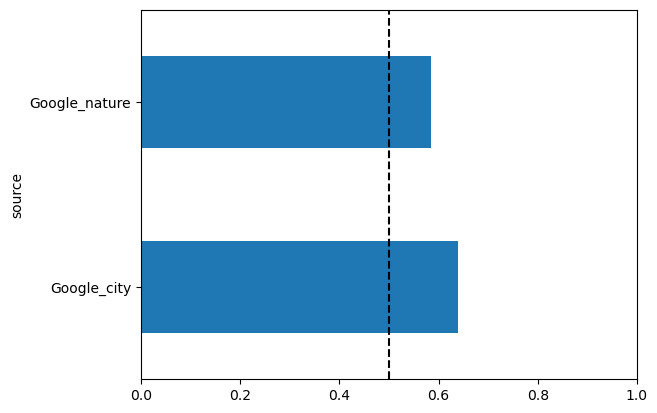

In [15]:
from sklearn.metrics import accuracy_score

test_source_df = pd.DataFrame({'source':test_source, 'category':test_category, 'pred':model.predict(test_df).argmax(axis=1)})
acc_source = test_source_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Background indices

In [16]:
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices_bg'))

df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)
train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)

In [17]:
model = get_model()

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 2)                 62        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x=train_df,
                    y=train_category,
                    epochs=50,
                    validation_data=(val_df, val_category),
                    callbacks=callback,
                    sample_weight=train_weight)


Epoch 1/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7252 - accuracy: 0.5742 - weighted_accuracy: 0.5742 - val_loss: 0.6477 - val_accuracy: 0.6405 - val_weighted_accuracy: 0.6405
Epoch 2/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6752 - accuracy: 0.6045 - weighted_accuracy: 0.6045 - val_loss: 0.6356 - val_accuracy: 0.6358 - val_weighted_accuracy: 0.6358
Epoch 3/50
373/373 [==============================] - 0s 1ms/step - loss: 0.6636 - accuracy: 0.6107 - weighted_accuracy: 0.6107 - val_loss: 0.6299 - val_accuracy: 0.6351 - val_weighted_accuracy: 0.6351
Epoch 4/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6582 - accuracy: 0.6205 - weighted_accuracy: 0.6205 - val_loss: 0.6309 - val_accuracy: 0.6365 - val_weighted_accuracy: 0.6365
Epoch 5/50
373/373 [==============================] - 1s 1ms/step - loss: 0.6532 - accuracy: 0.6199 - weighted_accuracy: 0.6199 - val_loss: 0.6307 - val_accuracy: 0.6331 - val_weighted_accurac

In [19]:
loss, accuracy, w_acc = model.evaluate(x=test_df, y=test_category)


8/8 [==============================] - 0s 1ms/step - loss: 0.6567 - accuracy: 0.6379 - weighted_accuracy: 0.6379


8/8 [==============================] - 0s 1ms/step


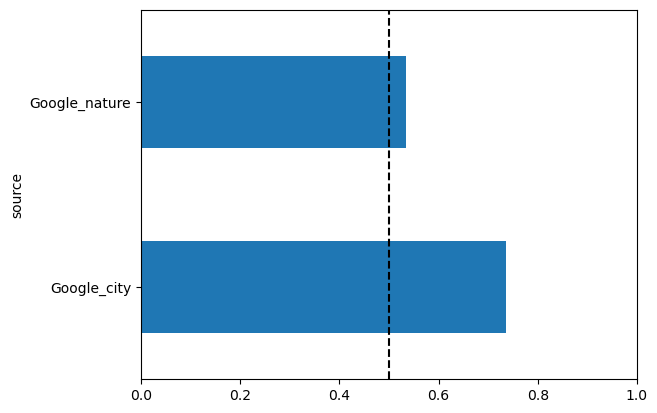

In [20]:
from sklearn.metrics import accuracy_score

test_source_df = pd.DataFrame({'source':test_source, 'category':test_category, 'pred':model.predict(test_df).argmax(axis=1)})
acc_source = test_source_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Foreground indices

In [21]:
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices_fg'))

df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)
train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)

In [22]:
model = get_model()

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 2)                 62        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(x=train_df,
                    y=train_category,
                    epochs=50,
                    validation_data=(val_df, val_category),
                    callbacks=callback,
                    sample_weight=train_weight)

Epoch 1/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7203 - accuracy: 0.5771 - weighted_accuracy: 0.5771 - val_loss: 0.6598 - val_accuracy: 0.6170 - val_weighted_accuracy: 0.6170
Epoch 2/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6738 - accuracy: 0.6029 - weighted_accuracy: 0.6029 - val_loss: 0.6451 - val_accuracy: 0.6244 - val_weighted_accuracy: 0.6244
Epoch 3/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6643 - accuracy: 0.6052 - weighted_accuracy: 0.6052 - val_loss: 0.6454 - val_accuracy: 0.6237 - val_weighted_accuracy: 0.6237
Epoch 4/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.6121 - weighted_accuracy: 0.6121 - val_loss: 0.6420 - val_accuracy: 0.6304 - val_weighted_accuracy: 0.6304
Epoch 5/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6509 - accuracy: 0.6216 - weighted_accuracy: 0.6216 - val_loss: 0.6393 - val_accuracy: 0.6338 - val_weighted_accurac

In [24]:
loss, accuracy, w_acc = model.evaluate(x=test_df, y=test_category)


8/8 [==============================] - 0s 2ms/step - loss: 0.6525 - accuracy: 0.5885 - weighted_accuracy: 0.5885


8/8 [==============================] - 0s 1ms/step


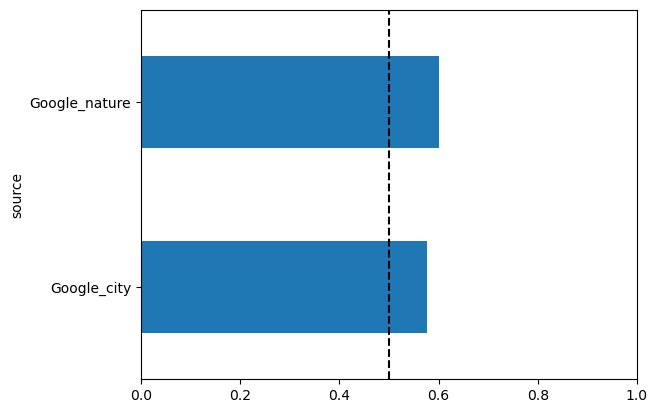

In [25]:
from sklearn.metrics import accuracy_score

test_source_df = pd.DataFrame({'source':test_source, 'category':test_category, 'pred':model.predict(test_df).argmax(axis=1)})
acc_source = test_source_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# all 3 indices

In [26]:
df_raw_list = []
df_bg_list = []
df_fg_list = []
for index, row in meta_df.iterrows():
    df_raw_list.append(load_df_pkl(row['file'], indices='df_indices'))
    df_bg_list.append(load_df_pkl(row['file'], indices='df_indices_bg'))
    df_fg_list.append(load_df_pkl(row['file'], indices='df_indices_fg'))

df_raw = pd.concat(df_raw_list, ignore_index=True)
df_raw.columns = list('raw_'+df_raw.columns)    

df_bg = pd.concat(df_bg_list, ignore_index=True)
df_bg.columns = list('bg_'+df_bg.columns)

df_fg = pd.concat(df_fg_list, ignore_index=True)
df_fg.columns = list('fg_'+df_fg.columns)

In [30]:
df = pd.concat([df_raw, df_bg, df_fg, meta_df[['category','fold','source','weight']]], axis=1)
train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(180), dtype=tf.float32),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2)
        ])

loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss_func,
              optimizer=optimizer,
              weighted_metrics=['accuracy'],
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 30)                5430      
                                                                 
 dense_1 (Dense)             (None, 2)                 62        
                                                                 
Total params: 5,492
Trainable params: 5,492
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(x=train_df,
                    y=train_category,
                    epochs=50,
                    validation_data=(val_df, val_category),
                    callbacks=callback,
                    sample_weight=train_weight)

Epoch 1/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7379 - accuracy: 0.5895 - weighted_accuracy: 0.5895 - val_loss: 0.6334 - val_accuracy: 0.6432 - val_weighted_accuracy: 0.6432
Epoch 2/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6639 - accuracy: 0.6235 - weighted_accuracy: 0.6235 - val_loss: 0.6270 - val_accuracy: 0.6452 - val_weighted_accuracy: 0.6452
Epoch 3/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6503 - accuracy: 0.6245 - weighted_accuracy: 0.6245 - val_loss: 0.6200 - val_accuracy: 0.6412 - val_weighted_accuracy: 0.6412
Epoch 4/50
373/373 [==============================] - 1s 1ms/step - loss: 0.6377 - accuracy: 0.6365 - weighted_accuracy: 0.6365 - val_loss: 0.6180 - val_accuracy: 0.6439 - val_weighted_accuracy: 0.6439
Epoch 5/50
373/373 [==============================] - 1s 1ms/step - loss: 0.6364 - accuracy: 0.6400 - weighted_accuracy: 0.6400 - val_loss: 0.6200 - val_accuracy: 0.6405 - val_weighted_accurac

In [35]:
loss, accuracy, w_acc = model.evaluate(x=test_df, y=test_category)


8/8 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6255 - weighted_accuracy: 0.6255


8/8 [==============================] - 0s 2ms/step


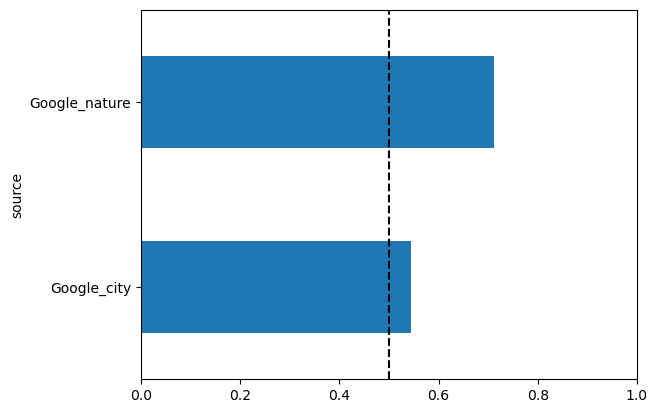

In [36]:
from sklearn.metrics import accuracy_score

test_source_df = pd.DataFrame({'source':test_source, 'category':test_category, 'pred':model.predict(test_df).argmax(axis=1)})
acc_source = test_source_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Lazypredict

In [38]:
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [39]:
# raw signal
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices'))
    
df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)

train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)


X_train = train_df
y_train = train_category
X_valid = val_df
y_valid = val_category

transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
      ,('scaler', StandardScaler())
])

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_valid = transformer.transform(X_valid)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
models

100%|███████████████████████████████████████████| 29/29 [01:25<00:00,  2.96s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.65,0.65,0.65,0.65,0.20
RidgeClassifierCV,0.65,0.65,0.65,0.65,0.07
CalibratedClassifierCV,0.65,0.65,0.65,0.65,13.90
RidgeClassifier,0.65,0.65,0.65,0.65,0.03
AdaBoostClassifier,0.65,0.65,0.65,0.65,4.21
LinearSVC,0.65,0.65,0.65,0.65,4.07
LinearDiscriminantAnalysis,0.65,0.65,0.65,0.65,0.15
SVC,0.64,0.65,0.65,0.64,11.87
LGBMClassifier,0.64,0.64,0.64,0.64,0.35


In [40]:
# background signal
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices_bg'))
    
df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)

train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)


X_train = train_df
y_train = train_category
X_valid = val_df
y_valid = val_category

transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
      ,('scaler', StandardScaler())
])

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_valid = transformer.transform(X_valid)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
models

100%|███████████████████████████████████████████| 29/29 [01:28<00:00,  3.06s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.66,0.66,0.66,0.66,3.97
SVC,0.65,0.66,0.66,0.65,11.76
CalibratedClassifierCV,0.65,0.65,0.65,0.65,15.08
RidgeClassifier,0.65,0.65,0.65,0.65,0.03
LogisticRegression,0.65,0.65,0.65,0.65,0.18
LinearDiscriminantAnalysis,0.65,0.65,0.65,0.65,0.15
RidgeClassifierCV,0.65,0.65,0.65,0.65,0.06
AdaBoostClassifier,0.65,0.65,0.65,0.65,3.93
RandomForestClassifier,0.65,0.65,0.65,0.65,6.85


In [41]:
# foreground signal
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices_fg'))
    
df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)

train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)


X_train = train_df
y_train = train_category
X_valid = val_df
y_valid = val_category

transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
      ,('scaler', StandardScaler())
])

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_valid = transformer.transform(X_valid)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
models

100%|███████████████████████████████████████████| 29/29 [01:30<00:00,  3.10s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.65,0.65,0.65,0.65,12.12
LinearDiscriminantAnalysis,0.63,0.63,0.63,0.63,0.13
LogisticRegression,0.63,0.63,0.63,0.63,0.17
RandomForestClassifier,0.63,0.63,0.63,0.63,7.01
LGBMClassifier,0.63,0.63,0.63,0.63,0.35
RidgeClassifierCV,0.63,0.63,0.63,0.63,0.06
LinearSVC,0.63,0.63,0.63,0.63,3.73
RidgeClassifier,0.63,0.63,0.63,0.63,0.03
CalibratedClassifierCV,0.63,0.63,0.63,0.63,13.35


In [42]:
# all 3
df_raw_list = []
df_bg_list = []
df_fg_list = []
for index, row in meta_df.iterrows():
    df_raw_list.append(load_df_pkl(row['file'], indices='df_indices'))
    df_bg_list.append(load_df_pkl(row['file'], indices='df_indices_bg'))
    df_fg_list.append(load_df_pkl(row['file'], indices='df_indices_fg'))

df_raw = pd.concat(df_raw_list, ignore_index=True)
df_raw.columns = list('raw_'+df_raw.columns)    

df_bg = pd.concat(df_bg_list, ignore_index=True)
df_bg.columns = list('bg_'+df_bg.columns)

df_fg = pd.concat(df_fg_list, ignore_index=True)
df_fg.columns = list('fg_'+df_fg.columns)

df = pd.concat([df_raw, df_bg, df_fg, meta_df[['category','fold','source','weight']]], axis=1)
train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)


X_train = train_df
y_train = train_category
X_valid = val_df
y_valid = val_category

transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
      ,('scaler', StandardScaler())
])

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_valid = transformer.transform(X_valid)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
models

100%|███████████████████████████████████████████| 29/29 [02:51<00:00,  5.93s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.66,0.66,0.66,0.66,0.41
RidgeClassifierCV,0.66,0.66,0.66,0.66,0.25
CalibratedClassifierCV,0.66,0.66,0.66,0.66,28.78
LGBMClassifier,0.66,0.66,0.66,0.66,0.83
RidgeClassifier,0.66,0.66,0.66,0.66,0.09
LinearSVC,0.66,0.66,0.66,0.66,7.57
LogisticRegression,0.66,0.66,0.66,0.66,0.35
SVC,0.65,0.66,0.66,0.65,22.36
XGBClassifier,0.65,0.65,0.65,0.65,7.25


# Apply PCA dimensional reduction

In [43]:
# raw signal
df_list = []
for index, row in meta_df.iterrows():
    df_list.append(load_df_pkl(row['file'], indices='df_indices'))
    
df = pd.concat(df_list, ignore_index=True)
df = pd.concat([df, meta_df[['category','fold','source','weight']]], axis=1)

train_df, val_df, test_df, train_category, val_category, test_category, train_source, val_source, test_source, train_weight = df_preproc(df)


X_train = train_df
y_train = train_category
X_valid = val_df
y_valid = val_category

transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
      ,('scaler', StandardScaler())
])

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_valid = transformer.transform(X_valid)

In [85]:
from sklearn.decomposition import PCA

PCA_perc = 0.9
pca = PCA(n_components = PCA_perc, random_state=23)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)
print(str(X_train_pca.shape[1])+' PCs explained '+str(PCA_perc*100)+'% of variance.')

20 PCs explained 90.0% of variance.


In [86]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_pca, X_valid_pca, y_train, y_valid)
models

100%|███████████████████████████████████████████| 29/29 [00:55<00:00,  1.90s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.65,0.65,0.65,0.65,7.95
LGBMClassifier,0.63,0.63,0.63,0.63,0.18
CalibratedClassifierCV,0.63,0.63,0.63,0.63,4.18
NearestCentroid,0.63,0.63,0.63,0.63,0.02
LogisticRegression,0.63,0.63,0.63,0.63,0.04
LinearSVC,0.63,0.63,0.63,0.63,1.40
RidgeClassifierCV,0.62,0.62,0.62,0.62,0.03
LinearDiscriminantAnalysis,0.62,0.62,0.62,0.62,0.05
RidgeClassifier,0.62,0.62,0.62,0.62,0.02


In [87]:
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)

model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(X_train_pca.shape[1]), dtype=tf.float32),
tf.keras.layers.Dropout(.2),
tf.keras.layers.Dense(20, activation='relu'),
tf.keras.layers.Dropout(.2),
tf.keras.layers.Dense(20, activation='relu'),
tf.keras.layers.Dropout(.2),
tf.keras.layers.Dense(20, activation='relu'),
tf.keras.layers.Dense(2)
])

loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss_func,
              optimizer=optimizer,
              weighted_metrics=['accuracy'],
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 4

In [88]:
history = model.fit(x=X_train_pca,
                    y=y_train,
                    epochs=50,
                    validation_data=(X_valid_pca, y_valid),
                    callbacks=callback,
                    sample_weight=train_weight)

Epoch 1/50
373/373 [==============================] - 2s 2ms/step - loss: 0.7087 - accuracy: 0.5433 - weighted_accuracy: 0.5433 - val_loss: 0.6764 - val_accuracy: 0.5674 - val_weighted_accuracy: 0.5674
Epoch 2/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6808 - accuracy: 0.5750 - weighted_accuracy: 0.5750 - val_loss: 0.6593 - val_accuracy: 0.6271 - val_weighted_accuracy: 0.6271
Epoch 3/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6685 - accuracy: 0.5967 - weighted_accuracy: 0.5967 - val_loss: 0.6488 - val_accuracy: 0.6338 - val_weighted_accuracy: 0.6338
Epoch 4/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6674 - accuracy: 0.5979 - weighted_accuracy: 0.5979 - val_loss: 0.6481 - val_accuracy: 0.6358 - val_weighted_accuracy: 0.6358
Epoch 5/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6651 - accuracy: 0.6014 - weighted_accuracy: 0.6014 - val_loss: 0.6505 - val_accuracy: 0.6345 - val_weighted_accurac